<h1 style="text-align: center;">Choice of the number of hidden layers for back propagation neural network driven by stock price data and application to price prediction</h1>

## 1. Exploratory data analysis

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import jarque_bera

In [4]:
# Parameters
TICKER = "601398.SS"   # ICBC stock on the Shanghai Exchange       
START  = "2016-06-01"
END    = "2018-06-27"

# Download data from Yahoo Finance
df = yf.download(TICKER, start=START, end=END, auto_adjust=False)
df = df.sort_index()

# Compute log-returns of Close
close = df["Close"].astype(float)
logret = np.log(close).diff()
df["logret_close"] = logret

# Summary statistics
x = df["logret_close"].dropna()

print("\n=== Summary for close log-returns ===")
print(x.describe())  # count, mean, std, min, quartiles, max

skewness = x.skew()
kurtosis = x.kurtosis()   # Fisher definition: normal=0
jb_stat, jb_p = jarque_bera(x)

print("\n=== Extra stats ===")
print(f"Skewness     : {skewness:.6f}")
print(f"Kurtosis     : {kurtosis:.6f}")
print(f"Jarque-Bera  : {jb_stat:.6f}")
print(f"p-value (JB) : {jb_p:.6f}")

[*********************100%***********************]  1 of 1 completed


=== Summary for close log-returns ===
count    503.000000
mean       0.000442
std        0.012064
min       -0.067593
25%       -0.004530
50%        0.000000
75%        0.006309
max        0.059223
Name: logret_close, dtype: float64

=== Extra stats ===
Skewness     : -0.419391
Kurtosis     : 5.322939
Jarque-Bera  : 594.142805
p-value (JB) : 0.000000


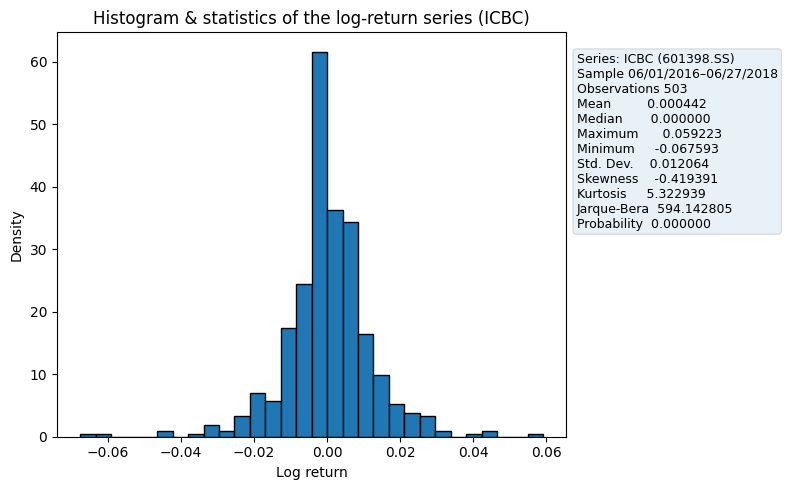

In [5]:
# Histogram with stats box
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.hist(x, bins=30, density=True, edgecolor="black")
ax.set_title("Histogram & statistics of the log-return series (ICBC)")
ax.set_xlabel("Log return")
ax.set_ylabel("Density")
stats_lines = [
    f"Series: ICBC ({TICKER})",
    f"Sample {pd.to_datetime(START).strftime('%m/%d/%Y')}–{pd.to_datetime(END).strftime('%m/%d/%Y')}",
    f"Observations {x.shape[0]}",
    f"Mean        {x.mean(): .6f}",
    f"Median      {x.median(): .6f}",
    f"Maximum     {x.max(): .6f}",
    f"Minimum     {x.min(): .6f}",
    f"Std. Dev.   {x.std(ddof=1): .6f}",
    f"Skewness    {skewness: .6f}",
    f"Kurtosis    {kurtosis: .6f}",
    f"Jarque-Bera {jb_stat: .6f}",
    f"Probability {jb_p: .6f}",
]
ax.text(1.02, 0.95, "\n".join(stats_lines), transform=ax.transAxes,fontsize=9, va="top", bbox=dict(boxstyle="round", alpha=0.1))
plt.tight_layout()
# plt.savefig("Histogram.png", dpi=300, bbox_inches='tight')
plt.show()

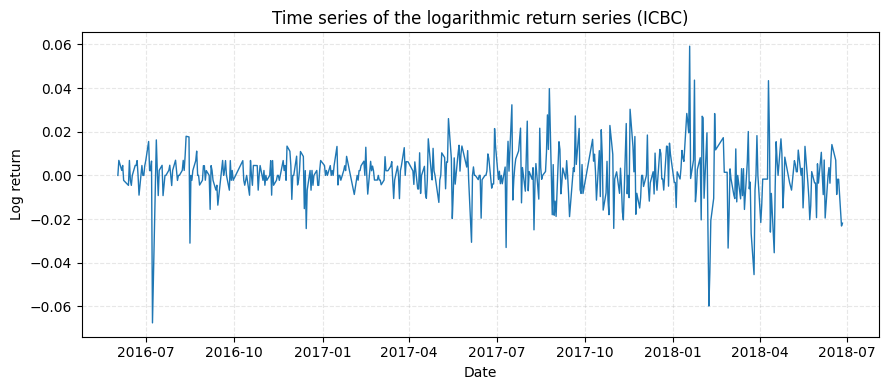

In [6]:
# Time series of log-returns
fig2 = plt.figure(figsize=(9, 4))
ax2 = fig2.add_subplot(111)
ax2.plot(df.index, df["logret_close"], linewidth=1)
ax2.set_title("Time series of the logarithmic return series (ICBC)")
ax2.set_xlabel("Date")
ax2.set_ylabel("Log return")
ax2.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()
# plt.savefig("logreturn.png", dpi=300, bbox_inches='tight')
plt.show()

## 2. Single-Hidden-Layer Prediction Model

In [8]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

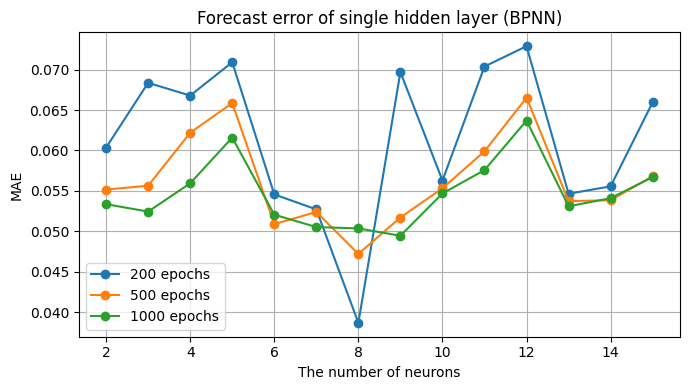

In [9]:
# 1) Build sliding-window features
def make_sliding_features(d, window=2):
    if "logret_open"   not in d.columns: d["logret_open"]   = np.log(d["Open"]).diff()
    if "logret_high"   not in d.columns: d["logret_high"]   = np.log(d["High"]).diff()
    if "logret_low"    not in d.columns: d["logret_low"]    = np.log(d["Low"]).diff()
    if "logret_volume" not in d.columns: d["logret_volume"] = np.log(d["Volume"].replace(0, np.nan)).diff()

    cols = [f"logret_{c}" for c in ["open","high","low","close","volume"]]

    feats = []
    for lag in range(window, -1, -1):   # t-2, t-1, t
        for c in cols:
            feats.append(d[c].shift(lag))
    X = pd.concat(feats, axis=1)
    X.columns = [f"{c}_t-{lag}" for lag in range(window,-1,-1) for c in cols]

    y = d["logret_close"].shift(-1)   # Target: next-day log-return of Close (in t+1)
    return X, y

X, y = make_sliding_features(df, window=2)

# 2) Train/Test split 
train_end  = pd.Timestamp("2018-06-04")
test_start = pd.Timestamp("2018-06-05")
test_end   = pd.Timestamp("2018-06-27")

mask_train = (X.index <= train_end)
mask_test  = (X.index >= test_start) & (X.index <= test_end)

X_train, y_train = X.loc[mask_train].dropna(), y.loc[mask_train].dropna()
idx_inter = X_train.index.intersection(y_train.index)
X_train, y_train = X_train.loc[idx_inter], y_train.loc[idx_inter]

X_test, y_test = X.loc[mask_test].dropna(), y.loc[mask_test].dropna()
idx_inter_t = X_test.index.intersection(y_test.index)
X_test, y_test = X_test.loc[idx_inter_t], y_test.loc[idx_inter_t]

close_series = df["Close"].astype(float)   # Close(t) needed to reconstruct predicted Close(t+1) = Close(t) * exp(pred_return)

# 3) Standardization helps SGD
scaler = StandardScaler().fit(X_train.values)
X_train_s = scaler.transform(X_train.values)
X_test_s = scaler.transform(X_test.values)

# 4) Grid search over neurons and epochs 
neurons_list = list(range(2, 16))   # s2 in {2,...,15}
epochs_list  = [200, 500, 1000]

def train_and_score(n_hidden, epochs):
    # Single hidden layer with sigmoid + SGD momentum
    model = MLPRegressor(
        hidden_layer_sizes=n_hidden,
        activation="logistic",
        solver="sgd",
        learning_rate_init=0.01,
        momentum=0.9,
        batch_size=32,
        max_iter=epochs,
        shuffle=True,
        n_iter_no_change=epochs + 1,   # Disable early stopping
        tol=0.0,
        random_state=3407
    )
    model.fit(X_train_s, y_train.values)
    pred = pd.DataFrame(index=X_test.index)
    pred["prev_close"] = close_series.reindex(X_test.index)
    pred["yhat_ret"]   = model.predict(X_test_s)
    pred["y_pred"]     = pred["prev_close"] * np.exp(pred["yhat_ret"])
    pred["y_true"]     = close_series.shift(-1).reindex(X_test.index)   # I predict C(t+1) so I need to shift in order to align
    pred = pred.dropna(subset=["y_pred", "y_true"])
    
    ytrue = pred["y_true"].to_numpy().reshape(-1)   # reshape(-1): matrix to vector
    ypred = pred["y_pred"].to_numpy().reshape(-1)
    mae = np.mean(np.abs(ytrue - ypred))   
    return mae, ypred, ytrue

results = {e: [] for e in epochs_list}
pred_store = {}

for e in epochs_list:
    for s in neurons_list:
        mae, yhat_price, ytrue = train_and_score((s,), e)
        results[e].append(mae)
        if e == 200 and s == 8:   # Setup showcased in Fig. 2
            pred_store[(s,e)] = (X_test.index, yhat_price, ytrue)

# 5) MAE vs number of neurons for 200/500/1000 epochs
plt.figure(figsize=(7,4))
for e in epochs_list:
    plt.plot(neurons_list, results[e], marker="o", label=f"{e} epochs")
plt.xlabel("The number of neurons")
plt.ylabel("MAE")
plt.title("Forecast error of single hidden layer (BPNN)")
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.savefig("MAE vs number of neurons.png", dpi=300, bbox_inches='tight')
plt.show()

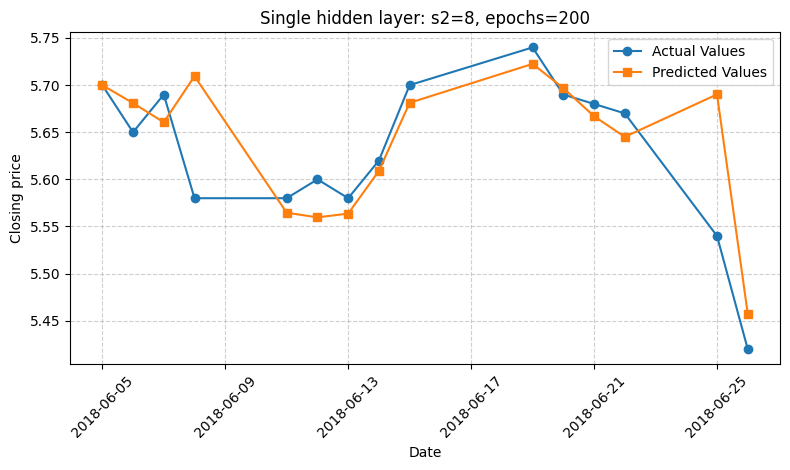

In [10]:
# 6) Actual vs Predicted closing prices for s2=8, epochs=200
s_best, e_best = 8, 200
dates, yhat_price, ytrue = pred_store[(s_best, e_best)]

start_value = df.loc[pd.Timestamp("2018-06-05"), "Close"]   # We predict t+1 so the first date that we predict is 06/06. To fit with the paper
                                                            # I add the real value of the close series in 05/06 for both yhat and ytrue                                                           
yhat_price = np.insert(yhat_price, 0, start_value)
ytrue = np.insert(ytrue, 0, start_value)
dates = dates.append(pd.Index([pd.Timestamp("2018-06-26")]))   # I passed X_test.index that ends with 25/06, but we have the prediction for the 26
                                                               
plt.figure(figsize=(8,4.8))
plt.plot(dates, ytrue, marker="o", label="Actual Values")
plt.plot(dates, yhat_price, marker="s", label="Predicted Values")
plt.xlabel("Date")
plt.ylabel("Closing price")
plt.title(f"Single hidden layer: s2={s_best}, epochs={e_best}")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig("Single actual vs predicted.png", dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# 7) Print MAE table (rows = neurons, cols = epochs)
mae_table = pd.DataFrame({e: results[e] for e in epochs_list}, index=neurons_list)
mae_table.index.name = "Neurons"
print("\nMAE (test)           Epochs")
print(mae_table.round(6))


MAE (test)           Epochs
             200       500       1000
Neurons                              
2        0.060359  0.055174  0.053364
3        0.068365  0.055644  0.052446
4        0.066789  0.062194  0.055942
5        0.070913  0.065868  0.061596
6        0.054572  0.050898  0.052064
7        0.052719  0.052399  0.050536
8        0.038688  0.047215  0.050368
9        0.069700  0.051716  0.049460
10       0.056284  0.055335  0.054686
11       0.070376  0.059895  0.057578
12       0.072898  0.066532  0.063697
13       0.054650  0.053738  0.053097
14       0.055570  0.053850  0.054108
15       0.065958  0.056822  0.056710


## 3. Multi-Hidden-Layers Prediction Model

In [13]:
# Architectures L=3,...,7
architectures = {
    3: (8,),      # Nb of parameters: 15 * 8 + 8 biases + 8 + 1 bias = 137
    4: (4, 10),   # Nb of parameters: 15 * 4 + 4 + 4 * 10 + 10 + 11 = 125 
    5: (5, 4, 4),
    6: (5, 5, 5, 5),
    7: (5, 5, 5, 5, 5)
}
EPOCHS = 200 
ytrue_out = close_series.shift(-1).reindex(X_test.index).to_numpy().reshape(-1)
dates_out = dates[1:]   # Remove the first date (05/06/2018)

mae_results = {}
table = pd.DataFrame({"Date": dates_out, "Actual Values": ytrue_out})
table = table.set_index("Date")
# Add predicted columns and MAE for each L
for L, arch in architectures.items():
    mae_tmp, ypred_vec, _ = train_and_score(arch, EPOCHS)
    table[f"L={L}"] = ypred_vec
    mae_results[L] = mae_tmp

print("\n==== Sample results of L-layer BPNN of ICBC ====\n")
print(table.round(4))

mae_table = pd.DataFrame.from_dict(mae_results, orient="index", columns=["MAE"])
mae_table.index.name = "Architecture (L)"

print("\n==== MAE summary table ====\n")
print(mae_table.round(6))


==== Sample results of L-layer BPNN of ICBC ====

            Actual Values     L=3     L=4     L=5     L=6     L=7
Date                                                             
2018-06-06           5.65  5.6809  5.7048  5.7013  5.7033  5.7074
2018-06-07           5.69  5.6606  5.6515  5.6606  5.6523  5.6573
2018-06-08           5.58  5.7095  5.6719  5.6967  5.6927  5.6974
2018-06-11           5.58  5.5646  5.6168  5.5868  5.5828  5.5872
2018-06-12           5.60  5.5597  5.5638  5.5926  5.5813  5.5870
2018-06-13           5.58  5.5636  5.6528  5.6072  5.6019  5.6066
2018-06-14           5.62  5.6090  5.6207  5.5854  5.5831  5.5871
2018-06-15           5.70  5.6812  5.6075  5.6201  5.6229  5.6272
2018-06-19           5.74  5.7225  5.7145  5.6977  5.7037  5.7072
2018-06-20           5.69  5.6968  5.7300  5.7391  5.7439  5.7478
2018-06-21           5.68  5.6670  5.6489  5.6996  5.6921  5.6975
2018-06-22           5.67  5.6450  5.6962  5.6881  5.6822  5.6871
2018-06-25           5.54

In [14]:
# Add first row in table with index 2018-06-05 and same true value
first_date = pd.Timestamp("2018-06-05")
first_value = df.loc[first_date, "Close"].item()
new_row = pd.DataFrame([ [first_value] * len(table.columns) ], columns=table.columns, index=[first_date])
table = pd.concat([new_row, table])
# print(table)

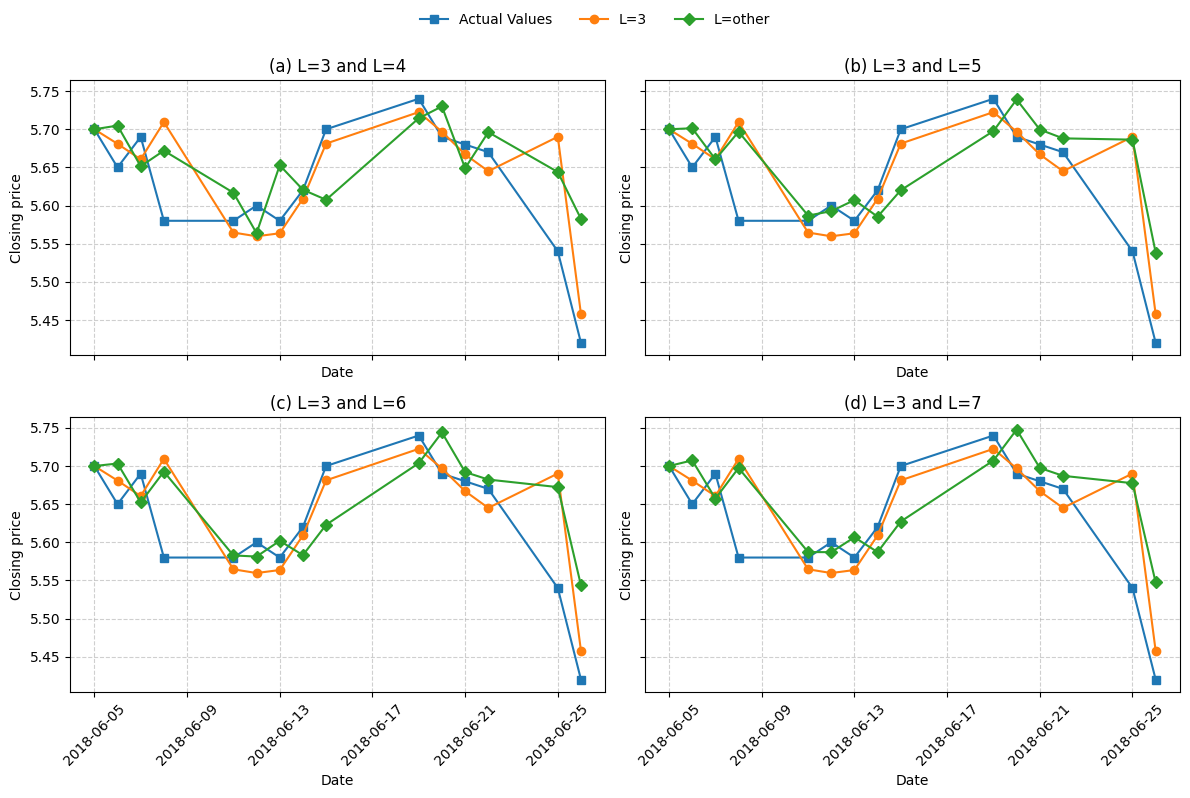

In [15]:
# Plot Actual vs L=3 and another L on the same axes
def plot_compare(L_other, ax, title):
    ax.plot(table.index, table["Actual Values"], marker="s", label="Actual Values")
    ax.plot(table.index, table["L=3"], marker="o", label="L=3")
    ax.plot(table.index, table[f"L={L_other}"], marker="D", label="L=other")
    ax.set_xlabel("Date")
    ax.set_ylabel("Closing price")
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.tick_params(axis="x", rotation=45)

# Create 2x2 grid 
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
plot_compare(4, axes[0,0], "(a) L=3 and L=4")
plot_compare(5, axes[0,1], "(b) L=3 and L=5")
plot_compare(6, axes[1,0], "(c) L=3 and L=6")
plot_compare(7, axes[1,1], "(d) L=3 and L=7")
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False)
fig.tight_layout(rect=[0,0,1,0.95])
# plt.savefig("Multi actual vs predicted.png", dpi=300, bbox_inches='tight')
plt.show()

## 4. ARIMA

In [55]:
warnings.filterwarnings("ignore")
from statsmodels.tsa.arima.model import ARIMA

# ARIMA: order selection on the same training period used for the MLP
train_close = close_series.loc[:train_end]

p_values = range(0, 4)
d_values = range(0, 3)
q_values = range(0, 4)

best_aic = np.inf
best_order = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            if p == 0 and d == 0 and q == 0:
                continue
            try:
                model = ARIMA(train_close, order=(p, d, q))
                res = model.fit()
                if res.aic < best_aic:
                    best_aic   = res.aic
                    best_order = (p, d, q)
            except Exception:
                # Skip parameter combinations that fail to converge
                continue

print(f"Best ARIMA(p,d,q) on training set by AIC: {best_order}, AIC = {best_aic:.2f}")

Best ARIMA(p,d,q) on training set by AIC: (2, 1, 2), AIC = -1200.95


In [18]:
best_neurons = (8,)
best_epochs = 200

mae_mlp_best, yhat_mlp_vec, ytrue_mlp_vec = train_and_score(best_neurons, best_epochs)

y_true_series = close_series.shift(-1).reindex(X_test.index).dropna()
test_eval_index = y_true_series.index

mlp_true = y_true_series.copy()
mlp_pred = pd.Series(yhat_mlp_vec, index=test_eval_index)

# Rolling one-step-ahead forecasts using true data (fixed ARIMA parameters)
# Refit ARIMA once on the training sample using a plain numpy array
train_close_np = train_close.values
arima_train_model = ARIMA(train_close_np, order=best_order)
arima_train_res = arima_train_model.fit()

# Full close series as numpy for incremental updates
full_close_np = close_series.values
all_dates = close_series.index

train_last_pos = all_dates.get_loc(train_end)

current_res = arima_train_res   # Fixed parameters, state will be updated with true data
last_pos = train_last_pos

arima_pred_values = []

for t in test_eval_index:
    t_pos = all_dates.get_loc(t)

    # Append all true observations from (last_pos + 1) up to t
    if t_pos > last_pos:
        new_segment = full_close_np[last_pos + 1 : t_pos + 1]
        if new_segment.size > 0:
            current_res = current_res.append(new_segment, refit=False)
            last_pos = t_pos

    # One-step-ahead forecast: Close(t+1), based only on true data up to date t
    yhat_next = current_res.forecast(steps=1)[0]
    arima_pred_values.append(yhat_next)

# Align ARIMA predictions with the same index used for the MLP evaluation (dates t)
arima_pred = pd.Series(arima_pred_values, index=test_eval_index)

mae_arima = mean_absolute_error(mlp_true.values, arima_pred.values)
print(f"Test MAE ARIMA{best_order}: {mae_arima:.6f}")

Test MAE ARIMA(2, 1, 2): 0.051435


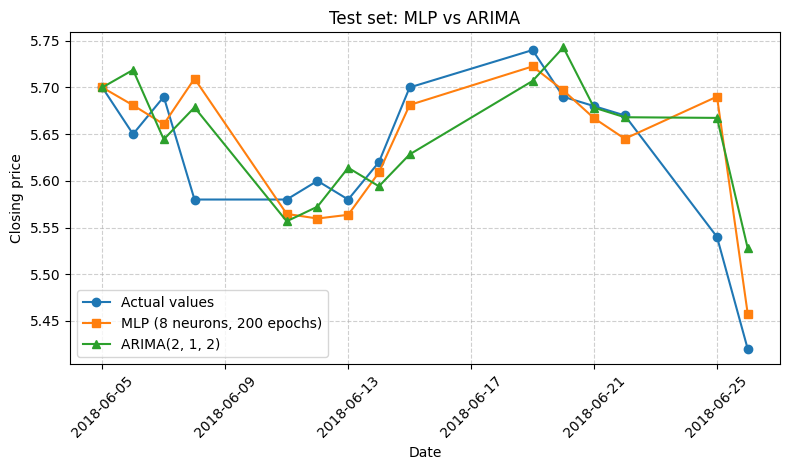

In [19]:
arima_with_start = np.insert(arima_pred.values, 0, start_value)

# Plot: MLP vs ARIMA on the test set
plt.figure(figsize=(8, 4.8))
plt.plot(dates, ytrue, marker="o", label="Actual values")
plt.plot(dates, yhat_price, marker="s", label="MLP (8 neurons, 200 epochs)")
plt.plot(dates, arima_with_start, marker="^", label=f"ARIMA{best_order}")

plt.xlabel("Date")
plt.ylabel("Closing price")
plt.title("Test set: MLP vs ARIMA")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig("ARIMA.png", dpi=300, bbox_inches='tight')
plt.show()

## 5. SVM

In [21]:
from sklearn.svm import SVR

# SVM model selection on the same training period used for the MLP
# We use a simple validation split inside the training set to choose (C, epsilon, gamma),
# then refit the best SVR on the full training data (X_train_s, y_train)
X_tr_full = np.asarray(X_train_s)
y_tr_full = np.asarray(y_train).ravel()

n_tr = X_tr_full.shape[0]
split = int(n_tr * 0.8)

X_tr, X_val = X_tr_full[:split], X_tr_full[split:]
y_tr_, y_val = y_tr_full[:split], y_tr_full[split:]

C_list = [1, 10, 100]
epsilon_list = [0.001, 0.01, 0.1]
gamma_list = ["scale", "auto"]

best_cfg = None
best_mae_val = np.inf

for C in C_list:
    for eps in epsilon_list:
        for g in gamma_list:
            svr = SVR(kernel="rbf", C=C, epsilon=eps, gamma=g)
            svr.fit(X_tr, y_tr_)
            y_val_hat = svr.predict(X_val)
            mae_val = mean_absolute_error(y_val, y_val_hat)
            if mae_val < best_mae_val:
                best_mae_val = mae_val
                best_cfg = (C, eps, g)

print(f"Best SVR params on validation: C={best_cfg[0]}, epsilon={best_cfg[1]}, gamma='{best_cfg[2]}', "f"val MAE={best_mae_val:.6f}")

Best SVR params on validation: C=1, epsilon=0.01, gamma='scale', val MAE=0.013260


In [22]:
# Refit best SVR on the full training data
best_svr = SVR(kernel="rbf", C=best_cfg[0], epsilon=best_cfg[1], gamma=best_cfg[2])
best_svr.fit(np.asarray(X_train_s), np.asarray(y_train).ravel())

# One-step-ahead forecasts on the test set using only true past values
# The sliding-window features in X_test_s are built from true historical data,
# so the SVR naturally performs one-step-ahead forecasts without using its own past predictions
yhat_ret_svm = best_svr.predict(np.asarray(X_test_s))

pred_svm = pd.DataFrame(index=X_test.index)
pred_svm["prev_close"] = close_series.reindex(X_test.index)
pred_svm["yhat_ret_svm"] = yhat_ret_svm
pred_svm["y_pred_svm"] = pred_svm["prev_close"] * np.exp(pred_svm["yhat_ret_svm"])
pred_svm["y_true"] = close_series.shift(-1).reindex(X_test.index)
pred_svm = pred_svm.dropna(subset=["y_pred_svm", "y_true"])

# Align SVR predictions with the same evaluation index used for the MLP
svm_pred_aligned = pred_svm["y_pred_svm"].reindex(test_eval_index)

svm_mae = mean_absolute_error(mlp_true.values, svm_pred_aligned.values)
print(f"Test MAE best SVR: {svm_mae:.6f}")

Test MAE best SVR: 0.070463


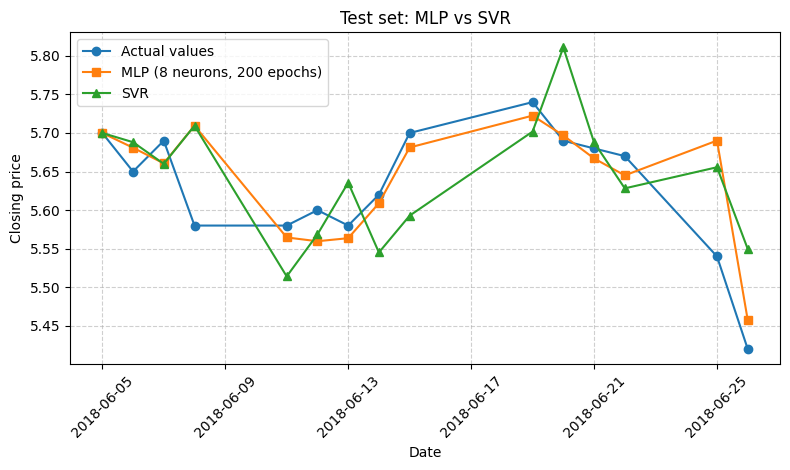

In [23]:
# Insert starting value so that the SVR curve matches (dates, ytrue, yhat_price) length
svm_with_start = np.insert(svm_pred_aligned.values, 0, start_value)

# Plot
plt.figure(figsize=(8, 4.8))
plt.plot(dates, ytrue, marker="o", label="Actual values")
plt.plot(dates, yhat_price, marker="s", label="MLP (8 neurons, 200 epochs)")
plt.plot(dates, svm_with_start, marker="^", label="SVR")

plt.xlabel("Date")
plt.ylabel("Closing price")
plt.title("Test set: MLP vs SVR")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig("SVM.png", dpi=300, bbox_inches='tight')
plt.show()

## 6. LSTM

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# For reproducibility
np.random.seed(3407)
tf.random.set_seed(3407)

# 1) Define past window length used as input
n_past = 10   # Number of past steps used as input

# 2) Build OHLCV feature matrix (all values as float32)
# We will use past lags of Close, Open, High, Low, Volume as covariates
ohlcv = df[["Close", "Open", "High", "Low", "Volume"]].astype("float32")
idx = ohlcv.index

# 3) Scale input features (X) using only the training period
train_mask_ohlcv = idx <= train_end
scaler_X = StandardScaler()
scaler_X.fit(ohlcv.loc[train_mask_ohlcv].values)
X_scaled_full = scaler_X.transform(ohlcv.values).astype("float32")

# 4) Scale target Close series (y) using only the training period
close_float = close_series.astype("float32")
scaler_y = StandardScaler()
scaler_y.fit(close_float.loc[:train_end].values.reshape(-1, 1))
y_scaled_full = (
    scaler_y.transform(close_float.values.reshape(-1, 1))
    .astype("float32")
    .flatten()
)

# 5) Build sliding windows on the scaled OHLCV data
#    X(t) = [OHLCV_scaled(t-n_past+1), ..., OHLCV_scaled(t)]
#    y(t) = Close_scaled(t+1)
#    and index each sample by date t so we can align with test_eval_index
X_list, y_list, idx_list = [], [], []
n_features = X_scaled_full.shape[1]

for i in range(n_past, len(idx) - 1):
    t_idx = idx[i]   # Date t
    # Use past n_past steps up to t as input
    X_seq = X_scaled_full[i - n_past + 1 : i + 1, :].reshape(n_past, n_features)
    # Predict Close at t+1 in scaled space
    y_val = y_scaled_full[i + 1]

    X_list.append(X_seq)
    y_list.append(y_val)
    idx_list.append(t_idx)

X_all = np.array(X_list, dtype="float32")   # Shape: (samples, n_past, n_features)
y_all = np.array(y_list, dtype="float32")   # Shape: (samples,)
idx_array = np.array(idx_list)              # Corresponding dates t

# 6) Train/test split with the same temporal split as the MLP
train_mask = idx_array <= train_end
test_mask = (idx_array >= test_start) & (idx_array <= test_end)

X_train_lstm = X_all[train_mask]
y_train_lstm = y_all[train_mask]

X_test_lstm = X_all[test_mask]
y_test_lstm = y_all[test_mask]
test_index_lstm = idx_array[test_mask]   # Dates t in the test window

# 7) Define and train the LSTM model on multivariate scaled data
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(n_past, n_features)),
    LSTM(64, return_sequences=False),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(1)
])

lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mae"
)

lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,393 (232.00 KB)

 Trainable params: 59,393 (232.00 KB)

 Non-trainable params: 0 (0.00 B)

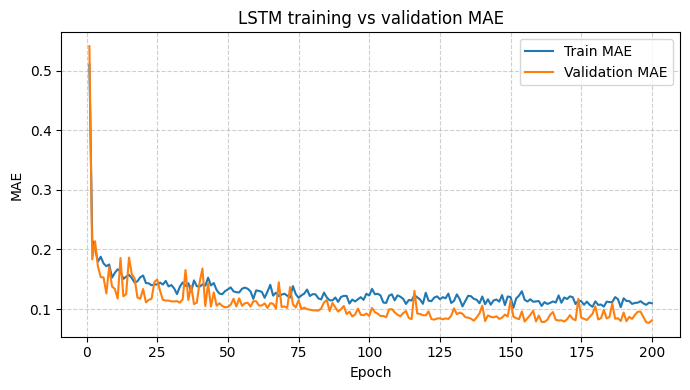

In [26]:
history_lstm = lstm_model.fit(
    X_train_lstm,
    y_train_lstm,
    epochs=200,          
    batch_size=32,
    validation_split=0.1,
    verbose=0
)

# Plot training and validation MAE over epochs
train_mae = history_lstm.history["loss"]
val_mae   = history_lstm.history["val_loss"]
epochs    = range(1, len(train_mae) + 1)

plt.figure(figsize=(7, 4))
plt.plot(epochs, train_mae, label="Train MAE")
plt.plot(epochs, val_mae, label="Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("LSTM training vs validation MAE")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
# plt.savefig("LSTM history.png", dpi=300, bbox_inches='tight')
plt.show()

In [27]:
# 8) One-step-ahead forecasts on test (still in scaled space)
yhat_lstm_scaled = lstm_model.predict(X_test_lstm, verbose=0).reshape(-1)

# 9) Inverse-transform predictions back to original Close price scale
yhat_lstm = scaler_y.inverse_transform(yhat_lstm_scaled.reshape(-1, 1)).reshape(-1)

# 10) Put predictions in a Series indexed by their t-dates
yhat_lstm_series = pd.Series(yhat_lstm, index=test_index_lstm)

# 11) Align with the same evaluation index used for the MLP (test_eval_index)
lstm_pred_aligned = yhat_lstm_series.reindex(test_eval_index)

# 12) Compute MAE only on dates where LSTM has a valid prediction
valid_mask = lstm_pred_aligned.notna()
mae_lstm = mean_absolute_error(
    mlp_true[valid_mask].values,
    lstm_pred_aligned[valid_mask].values
)

print(f"Test MAE LSTM: {mae_lstm:.6f}")

Test MAE LSTM: 0.054952


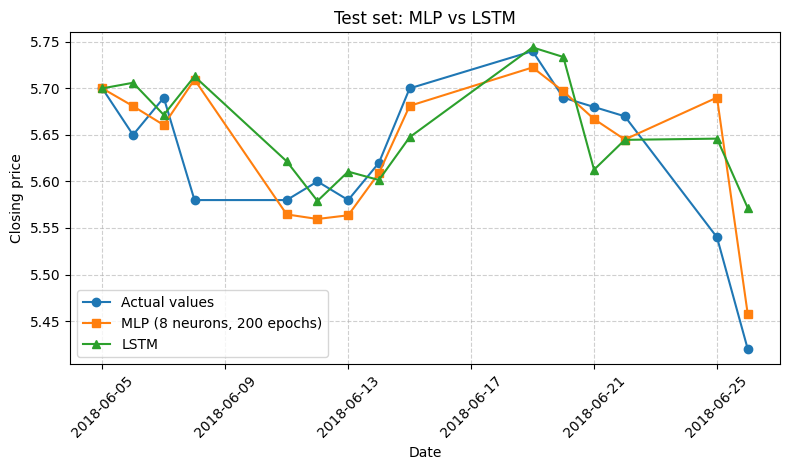

In [28]:
# Plot: MLP vs simple LSTM
lstm_with_start = np.insert(lstm_pred_aligned.values, 0, start_value)

plt.figure(figsize=(8, 4.8))
plt.plot(dates, ytrue, marker="o", label="Actual values")
plt.plot(dates, yhat_price, marker="s", label="MLP (8 neurons, 200 epochs)")
plt.plot(dates, lstm_with_start, marker="^", label="LSTM")

plt.xlabel("Date")
plt.ylabel("Closing price")
plt.title("Test set: MLP vs LSTM")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig("LSTM.png", dpi=300, bbox_inches='tight')
plt.show()

## 7. Hybrid model (ARIMA-LSTM)

In [30]:
warnings.filterwarnings("ignore")

# 1) Train/test split of Close series
test_start_date = dates[0]
test_end_date = dates[-1]

train_close_series = (close_series.loc[close_series.index < test_start_date].astype("float64").squeeze())   # DataFrame → Series

test_close_series = (close_series.reindex(dates).astype("float64").squeeze())       

# 2) Fit ARIMA on training data
arima_model = ARIMA(train_close_series, order=best_order)
arima_res = arima_model.fit()

# 3) ARIMA predictions (train + one-step-ahead test)
# In-sample ARIMA predictions on train
arima_train_pred = arima_res.predict(
    start=train_close_series.index[0],
    end=train_close_series.index[-1]
).reindex(train_close_series.index)

# Rolling one-step-ahead ARIMA on test
arima_test_pred_values = []
current_res = arima_res

for t in test_close_series.index:
    yhat_t = current_res.forecast(steps=1).iloc[0]
    arima_test_pred_values.append(yhat_t)
    current_res = current_res.append([test_close_series.loc[t]], refit=False)

arima_test_pred = pd.Series(arima_test_pred_values, index=test_close_series.index)

# 4) Compute residuals (train + test)
residual_train = (train_close_series - arima_train_pred).astype("float32")
residual_test = (test_close_series - arima_test_pred).astype("float32")

# 5) Standardize residuals (fit only on train)
scaler_res = StandardScaler()
scaler_res.fit(residual_train.values.reshape(-1,1))

res_train_std = scaler_res.transform(residual_train.values.reshape(-1,1))
res_test_std = scaler_res.transform(residual_test.values.reshape(-1,1))

# 6) Build sliding windows for LSTM training on residuals
n_past_res = 10
X_train_res, y_train_res = [], []

for i in range(n_past_res, len(res_train_std)):
    X_train_res.append(res_train_std[i-n_past_res:i])
    y_train_res.append(res_train_std[i])

X_train_res = np.array(X_train_res).reshape(-1, n_past_res, 1)
y_train_res = np.array(y_train_res).reshape(-1, 1)

# 7) Train LSTM on standardized residuals
hybrid_lstm = Sequential([
    LSTM(32, input_shape=(n_past_res, 1)),
    Dense(1)
])

hybrid_lstm.compile(optimizer=Adam(learning_rate=0.001), loss="mae")

history_hybrid = hybrid_lstm.fit(
    X_train_res,
    y_train_res,
    epochs=200,
    batch_size=32,
    validation_split=0.1 if len(X_train_res) >= 20 else 0.0,
    verbose=0
)

# 8) Build sliding windows for test residuals 
# Build clean dataframe of standardized test residuals
res_test_df = pd.DataFrame({
    "res_std": res_test_std.reshape(-1),
}, index=residual_test.index)

res_test_df = res_test_df.dropna()

vals = res_test_df["res_std"].values
idx = res_test_df.index
T = len(res_test_df)

X_test_res = []
test_dates_for_lstm = []

for i in range(n_past_res, T):
    window = vals[i-n_past_res:i]
    X_test_res.append(window)
    test_dates_for_lstm.append(idx[i])

X_test_res = np.array(X_test_res).reshape(-1, n_past_res, 1)

# 9) Predict standardized residuals for the TEST set
res_test_pred_std = hybrid_lstm.predict(X_test_res, verbose=0).reshape(-1,1)

# Inverse transform
res_test_pred = scaler_res.inverse_transform(res_test_pred_std).reshape(-1)

# Series of predicted residuals
res_test_pred_series = pd.Series(res_test_pred, index=test_dates_for_lstm)

# 10) Hybrid forecast = ARIMA forecast + predicted residuals
hybrid_forecast_series = arima_test_pred.copy()
hybrid_forecast_series.loc[res_test_pred_series.index] += res_test_pred_series

# 11) Compute MAE
hybrid_aligned = hybrid_forecast_series.reindex(dates)
mae_hybrid = mean_absolute_error(ytrue, hybrid_aligned.values)
print(f"Test MAE Hybrid (ARIMA + LSTM residual): {mae_hybrid:.6f}")

Test MAE Hybrid (ARIMA + LSTM residual): 0.050557


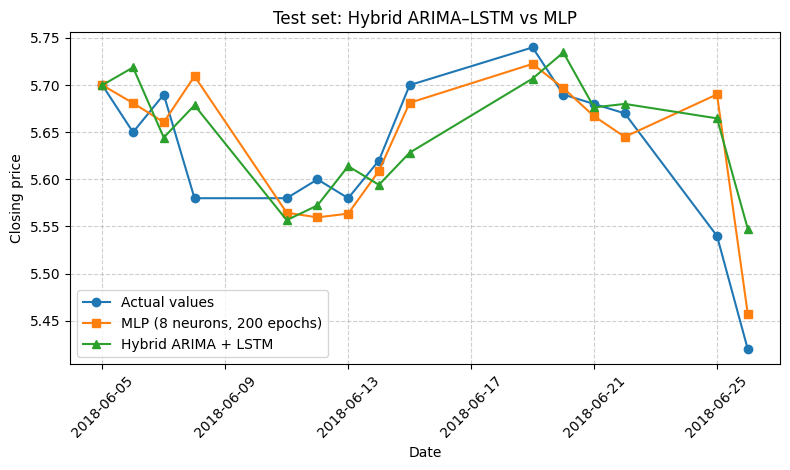

In [32]:
hybrid_aligned.values[0] = start_value

# Plot
plt.figure(figsize=(8, 4.8))
plt.plot(dates, ytrue, marker="o", label="Actual values")
plt.plot(dates, yhat_price, marker="s", label="MLP (8 neurons, 200 epochs)")
plt.plot(dates, hybrid_aligned.values, marker="^", label="Hybrid ARIMA + LSTM")

plt.xlabel("Date")
plt.ylabel("Closing price")
plt.title("Test set: Hybrid ARIMA–LSTM vs MLP")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig("Hybrid.png", dpi=300, bbox_inches='tight')
plt.show()